Proyecto Portafolios de inversión P2024 Rolando Fortanell, Ana Paula Moreno y Diego Lozoya

#Librerías

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Elección de activos

[*********************100%***********************]  16 of 16 completed
[*********************100%***********************]  15 of 15 completed


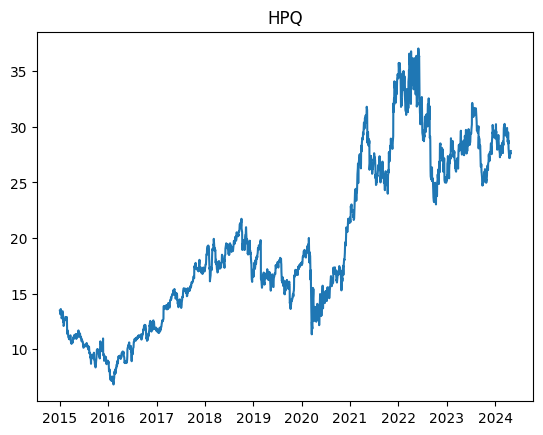

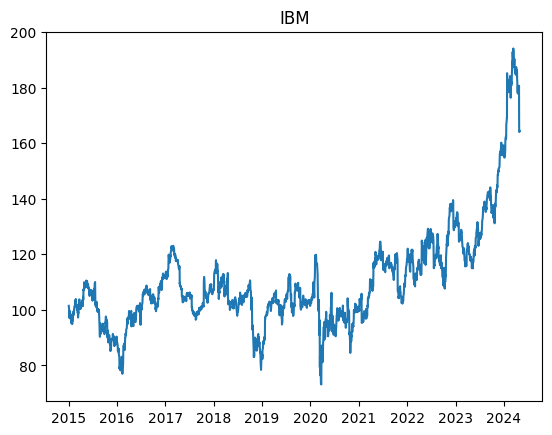

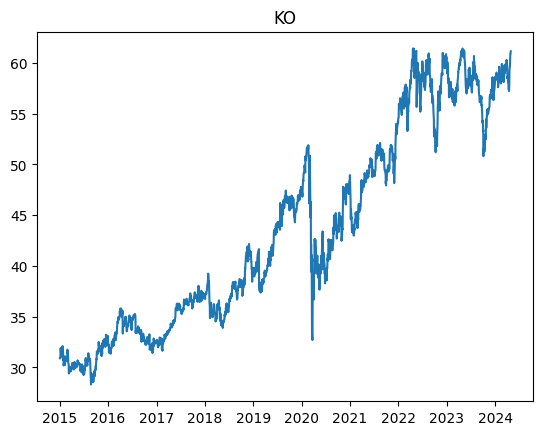

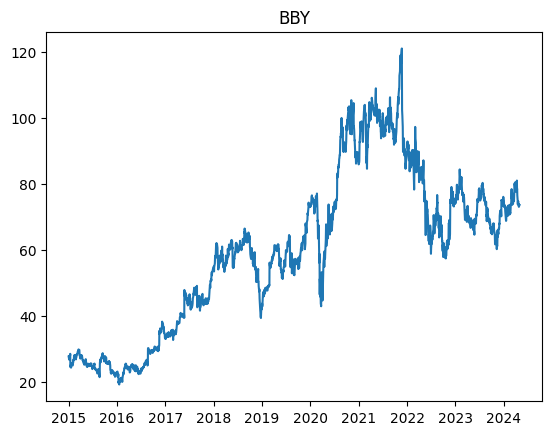

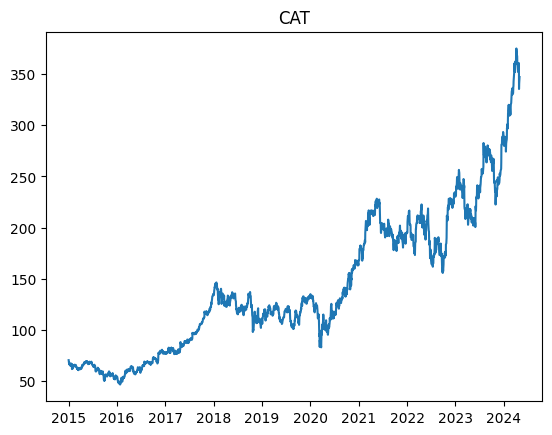

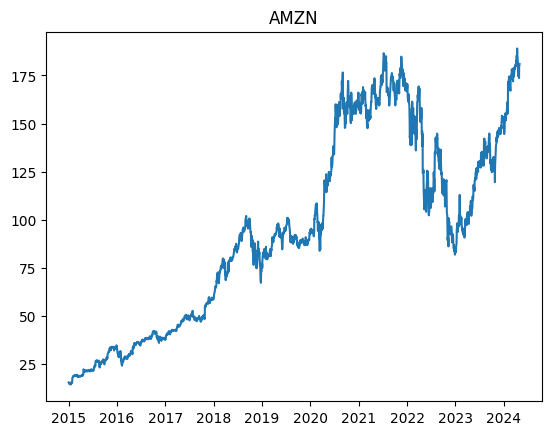

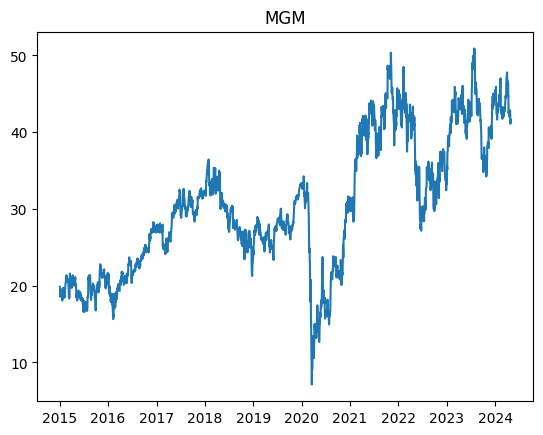

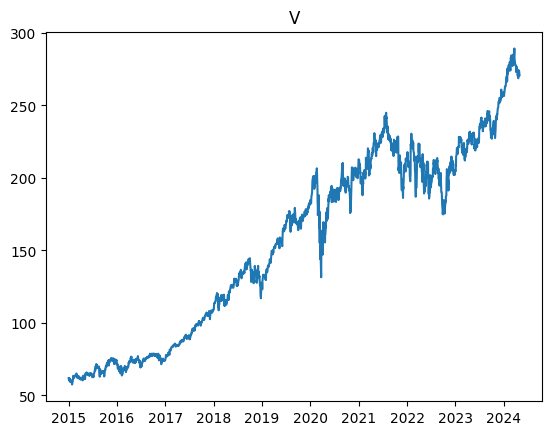

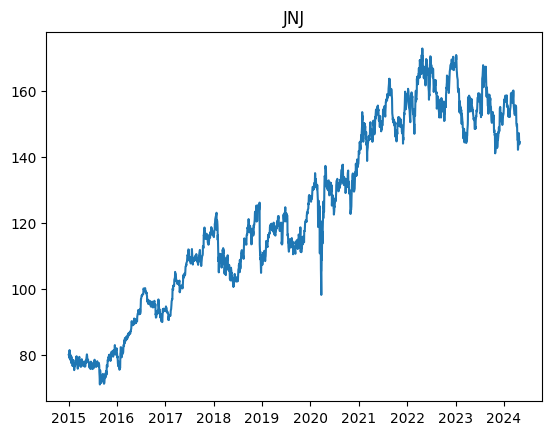

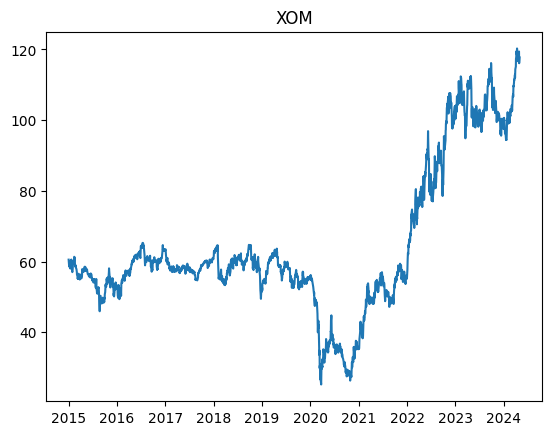

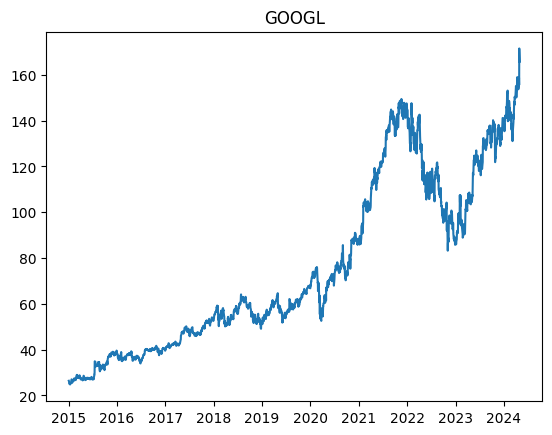

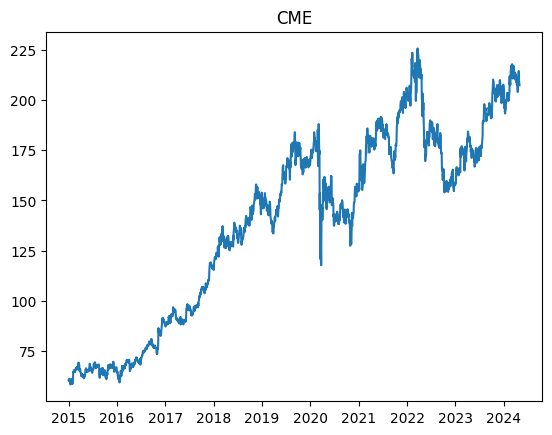

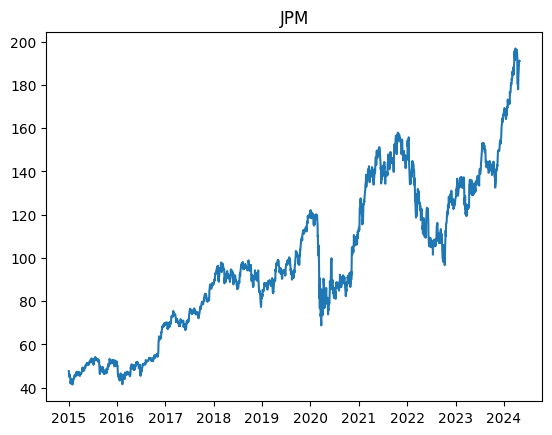

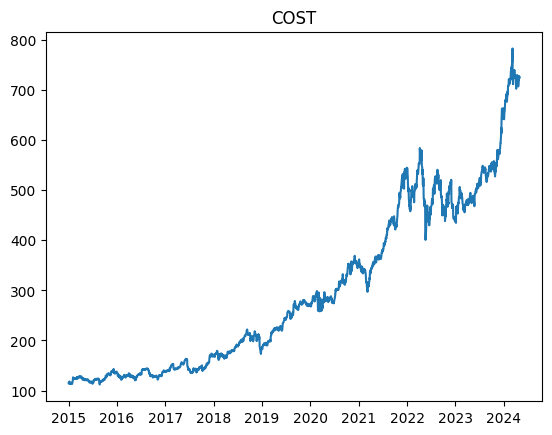

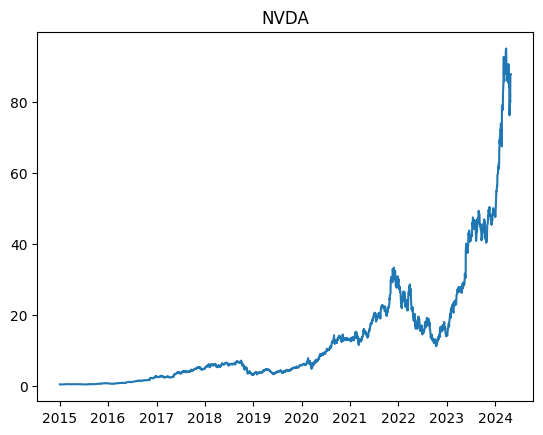

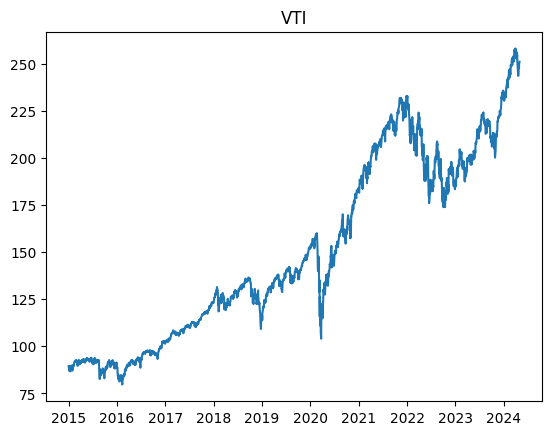

In [2]:
tickers = ['HPQ', 'IBM', 'KO', 'BBY', 'CAT',
           'AMZN', 'MGM', 'V', 'JNJ', 'XOM',
           'GOOGL', 'CME', 'JPM', 'COST', 'NVDA',
           'VTI']

tickers2 = tickers.copy()
tickers2.remove("VTI")
start_date = '2015-01-01'
end_date = "2024-04-30"


St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
Stock = yf.download(tickers2, start=start_date, end=end_date)['Adj Close']
rt = St.pct_change().dropna()
returns = Stock.pct_change().dropna()

for i in tickers:
    plt.figure()
    plt.plot(St[i])
    plt.title(i)

In [3]:
tickers = ['HPQ', 'IBM', 'KO', 'BBY', 'CAT',
           'AMZN', 'MGM', 'V', 'JNJ', 'XOM',
           'GOOGL', 'CME', 'JPM', 'COST', 'NVDA',
           'VTI']

tickers2 = tickers.copy()
tickers2.remove("VTI")
start_date = '2015-01-01'
end_date = "2024-04-30"


St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
Stock = yf.download(tickers2, start=start_date, end=end_date)['Adj Close']
rt = St.pct_change().dropna()
returns = Stock.pct_change().dropna()

[*********************100%***********************]  16 of 16 completed
[*********************100%***********************]  15 of 15 completed


In [4]:
r2s = []
betas = []
rendimiento = []
volatilidad = []

for i in tickers2:
    X = rt[["VTI"]]
    y = returns[[i]]

    #Calculo de beta
    model = LinearRegression().fit(X, y)
    beta = model.coef_[0][0]
    betas.append(beta)

    #Calculo de R2
    predictions = model.predict(X)
    r2 = r2_score(y_true=y, y_pred=predictions)
    r2s.append(r2)

    #Rendimiento
    rend = np.mean(returns[[i]]) * 252
    rendimiento.append(rend)

    #Volatilidad
    vol = np.std(returns[i]) * 252**(1/2)
    volatilidad.append(vol)

In [5]:
df = pd.DataFrame()
df["tickers"] = tickers2
df["betas"] = betas
df["r2"] = r2s
df["rendimientos"] = rendimiento
df["volatilidad"] = volatilidad

df

,tickers,betas,r2,rendimientos,volatilidad
0,HPQ,1.194999,0.410084,0.136673,0.340961
1,IBM,0.829306,0.396816,0.080926,0.240544
2,KO,0.588880,0.354403,0.089801,0.180739
3,BBY,1.125801,0.306557,0.173823,0.371518
4,CAT,1.056092,0.414218,0.216647,0.299821
5,AMZN,1.117112,0.381813,0.318988,0.330328
6,MGM,1.616580,0.416472,0.185253,0.457697
7,V,1.053288,0.601885,0.189380,0.248064
8,JNJ,0.537787,0.291995,0.080215,0.181843
9,XOM,0.873229,0.318569,0.111445,0.282684


#Selección de portafolios

In [6]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
tickers = tickers2.copy()
inicio = datetime.datetime(2010, 1, 1)
fin = datetime.datetime(2015, 12, 31)
libre_riesgo = [0.0022, 0.0057, 0.0087, 0.0178, 0.0252, 0.0152, 0.0010, 0.0039, 0.0450]
s = np.linspace(0, 0.25, 10)
datos = {}

for i in range(len(years)):
    #SELECCIÓN DE PORTAFOLIOS POR AÑO

    datos[years[i]] = []

    start_date = inicio.strftime("%Y-%m-%d")
    end_date = fin.strftime("%Y-%m-%d")

    St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    rt = St.pct_change().dropna()

    sigma = rt.cov()
    corr = rt.corr()

    rf = libre_riesgo[i]

    n_port = 50000
    n_act = len(rt.keys())

    W = np.random.dirichlet((1,) * n_act, size=n_port)

    rendimientos = W.dot(rt.mean()) * 252

    zeros = np.zeros(n_port)
    for j in range(len(zeros)):
        zeros[j] = W[j, :].dot(sigma).dot(W[j, :])
    volatility = zeros**(1/2) * 252**(1/2)

    sharpe = (rendimientos - rf) / volatility

    resultados = pd.DataFrame({
        "Expected_value": rendimientos,
        "Volatility": volatility,
        "Sharpe": sharpe
    })

    datos[years[i]].append(resultados.Volatility) #datos[years[i]][0]
    datos[years[i]].append(resultados.Expected_value) #datos[years[i]][1]

    for j in range(len(tickers)):
        ticker_temp = tickers[j]
        resultados["W_" + ticker_temp] = W[:, j]

    emv = resultados[resultados.Sharpe == resultados.Sharpe.max()]

    emv_volatility = emv.Volatility.values[0]
    emv_expected_value = emv.Expected_value.values[0]

    datos[years[i]].append(emv_volatility) #datos[years[i]][2]
    datos[years[i]].append(emv_expected_value) #datos[years[i]][3]

    pesos_emv = []

    for j in range(len(tickers)):
        ticker_temp = tickers[j]
        pesos_emv.append(emv["W_" + ticker_temp].values[0])

    datos[years[i]].append(pesos_emv) #datos[years[i]][4]

    gamma = np.linspace(1, 10, 10)

    lac_emv = pd.DataFrame({
        "gamma": gamma,
        "w_acciones": (emv_expected_value - rf) / (gamma * emv_volatility**2)
    })

    lac_emv["w_bonos"] = 1 - lac_emv.w_acciones

    media_lac = lac_emv.w_acciones * emv_expected_value + lac_emv.w_bonos * rf
    vol_lac = lac_emv.w_acciones * emv_expected_value

    media = []
    vol = []

    for j in range(len(media_lac)):
        media.append(media_lac.values[j])
        vol.append(vol_lac.values[j])

    lac_emv["media"] = media
    lac_emv["vol"] = vol

    distribucion = lac_emv[lac_emv.gamma == 8]
    w_bonos = distribucion.w_bonos.values[0]
    w_acciones = distribucion.w_acciones.values[0]

    datos[years[i]].append(w_bonos) #datos[years[i]][5]
    datos[years[i]].append(w_acciones) #datos[years[i]][6]

    lac = rf+s*emv.Sharpe.iloc[0]

    datos[years[i]].append(lac) #datos[years[i]][7]
    datos[years[i]].append(rf) #datos[years[i]][8]

    inicio += datetime.timedelta(days=365)
    fin += datetime.timedelta(days=365)

[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed
[*********************100%***********************]  15 of 15 completed


In [7]:
resultados

,Expected_value,Volatility,Sharpe,W_HPQ,W_IBM,W_KO,W_BBY,W_CAT,W_AMZN,W_MGM,W_V,W_JNJ,W_XOM,W_GOOGL,W_CME,W_JPM,W_COST,W_NVDA
0,0.182656,0.233895,0.588537,0.253011,0.026860,0.119364,0.101707,0.003590,0.036984,0.067789,0.014149,0.042805,0.014790,0.018501,0.066170,0.020643,0.165973,0.047663
1,0.189947,0.228535,0.634247,0.023929,0.157045,0.116935,0.037959,0.118842,0.033014,0.069680,0.018030,0.060128,0.111167,0.023410,0.014096,0.072428,0.113749,0.029587
2,0.222696,0.249450,0.712350,0.015168,0.051553,0.123748,0.002028,0.012358,0.113982,0.068065,0.135611,0.039432,0.038972,0.086171,0.025467,0.203295,0.009666,0.074485
3,0.162480,0.233881,0.502309,0.026160,0.007167,0.004035,0.061159,0.069081,0.133136,0.333992,0.037346,0.071668,0.123672,0.034211,0.002877,0.011810,0.008187,0.075497
4,0.224460,0.249611,0.718960,0.151011,0.035543,0.032127,0.057646,0.010783,0.073067,0.053445,0.001132,0.082353,0.077417,0.001449,0.023598,0.185084,0.007605,0.207741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.186345,0.251833,0.561265,0.053039,0.188389,0.149119,0.019433,0.032565,0.009078,0.080777,0.005039,0.028920,0.041690,0.030466,0.085304,0.068748,0.131131,0.076300
49996,0.176422,0.231834,0.566880,0.209988,0.009761,0.127356,0.029700,0.041562,0.071984,0.154266,0.001019,0.005763,0.067364,0.074383,0.039275,0.005324,0.039057,0.123200
49997,0.171345,0.225679,0.559841,0.081808,0.003234,0.126403,0.008494,0.089257,0.077157,0.016215,0.181637,0.063322,0.004002,0.102008,0.152258,0.024365,0.061641,0.008199
49998,0.262089,0.280380,0.774269,0.043984,0.194061,0.022159,0.010925,0.127564,0.012803,0.021744,0.028816,0.059205,0.011212,0.008007,0.082430,0.269184,0.091501,0.016405


#Evaluación del rendimiento

In [8]:
years2 = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
rf2 = [0.0057, 0.0087, 0.0178, 0.0252, 0.0152, 0.0010, 0.0039, 0.0450, 0.0457]
inicio = datetime.datetime(2016, 1, 1)
fin = datetime.datetime(2016, 12, 31)
rendimientos = {}
rend_anual = []

for i in range(len(years2)):
    start_date = inicio.strftime("%Y-%m-%d")
    end_date = fin.strftime("%Y-%m-%d")

    St = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    rt = St.pct_change().dropna()

    rendimientos[years2[i]] = pd.DataFrame()
    for j in range(len(tickers)):
        rendimientos[years2[i]]["rend_pond_" + tickers[j]] = St[tickers[j]] * datos[years[i]][4][j]

    rend_acciones = (rendimientos[years2[i]].sum(axis=1)[-1] - rendimientos[years2[i]].sum(axis=1)[0]) / rendimientos[years2[i]].sum(axis=1)[0]
    rend_total = rend_acciones * datos[years[i]][6] + rf2[i] * datos[years[i]][5]
    rend_anual.append(rend_total)

    inicio += datetime.timedelta(days=365)
    fin += datetime.timedelta(days=365)

rend_anual2 = [x + 1 for x in rend_anual]
e = np.cumprod(rend_anual2)

capital = 10000
monto = capital*e[-1]

rend_prom = (monto / capital)**(1/len(rend_anual)) - 1

[*********************100%***********************]  15 of 15 completed
<ipython-input-8-f5c4b8acaf6a>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rend_acciones = (rendimientos[years2[i]].sum(axis=1)[-1] - rendimientos[years2[i]].sum(axis=1)[0]) / rendimientos[years2[i]].sum(axis=1)[0]
<ipython-input-8-f5c4b8acaf6a>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rend_acciones = (rendimientos[years2[i]].sum(axis=1)[-1] - rendimientos[years2[i]].sum(axis=1)[0]) / rendimientos[years2[i]].sum(axis=1)[0]
<ipython-input-8-f5c4b8acaf6a>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. 

#Resultados

2016
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un 2.045% bonos y un 97.955% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 10.0466%
   IBM: 1.1412%
   KO: 1.2442%
   BBY: 1.8825%
   CAT: 59.0891%
   AMZN: 2.1502%
   MGM: 0.2134%
   V: 8.4569%
   JNJ: 3.5222%
   XOM: 0.2218%
   GOOGL: 0.2773%
   CME: 0.1522%
   JPM: 6.0748%
   COST: 1.2365%
   NVDA: 4.2912%


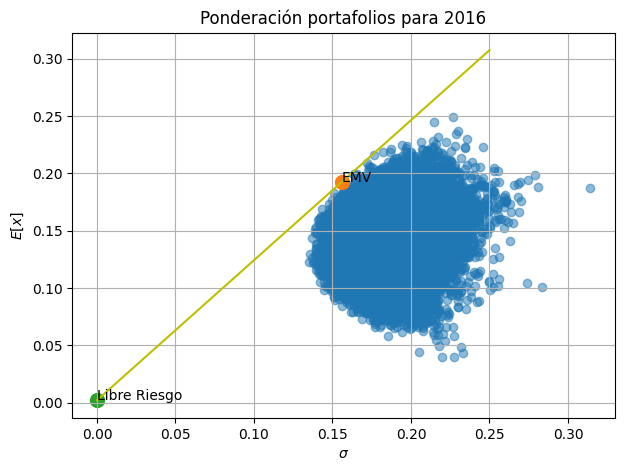

 El portafolio tiene un valor esperado del 19.231%, con una volatilidad del 15.5756%.
 El portafolio tuvo realmente un rendimiento del 32.6141%.

2017
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un -6.2956% bonos y un 106.2956% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 15.793%
   IBM: 0.1176%
   KO: 1.1031%
   BBY: 8.9163%
   CAT: 18.3906%
   AMZN: 5.3999%
   MGM: 0.7615%
   V: 1.6239%
   JNJ: 19.0845%
   XOM: 0.3775%
   GOOGL: 1.0364%
   CME: 0.0023%
   JPM: 12.7484%
   COST: 12.0912%
   NVDA: 2.5537%


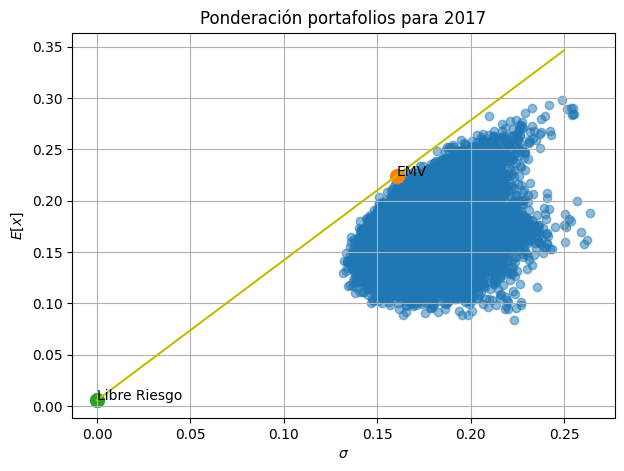

 El portafolio tiene un valor esperado del 22.4246%, con una volatilidad del 16.0313%.
 El portafolio tuvo realmente un rendimiento del 40.0141%.

2018
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un -71.4207% bonos y un 171.4207% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 10.6206%
   IBM: 0.2578%
   KO: 1.5796%
   BBY: 19.6359%
   CAT: 12.5915%
   AMZN: 1.9973%
   MGM: 1.3535%
   V: 0.589%
   JNJ: 12.0161%
   XOM: 5.2497%
   GOOGL: 1.2559%
   CME: 1.7622%
   JPM: 17.8771%
   COST: 12.0951%
   NVDA: 1.1188%


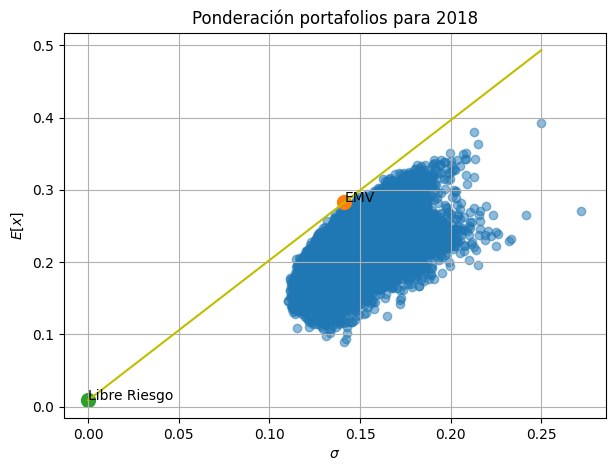

 El portafolio tiene un valor esperado del 28.2737%, con una volatilidad del 14.136%.
 El portafolio tuvo realmente un rendimiento del -12.4367%.

2019
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un -37.5699% bonos y un 137.5699% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 8.2788%
   IBM: 11.5109%
   KO: 2.1591%
   BBY: 30.532%
   CAT: 0.4536%
   AMZN: 3.7031%
   MGM: 11.3514%
   V: 1.4028%
   JNJ: 5.4629%
   XOM: 0.3451%
   GOOGL: 9.9887%
   CME: 0.9605%
   JPM: 8.0201%
   COST: 5.1129%
   NVDA: 0.7181%


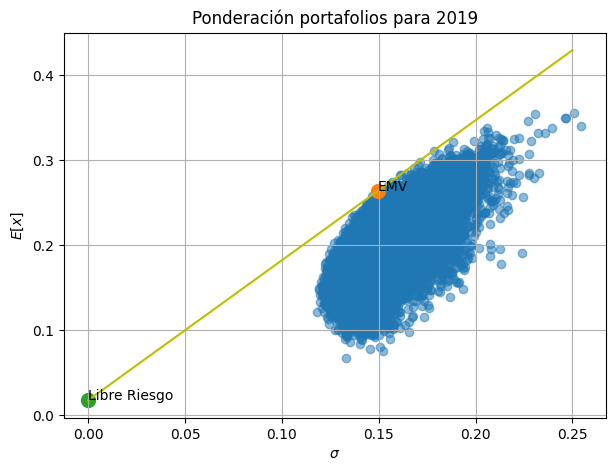

 El portafolio tiene un valor esperado del 26.4376%, con una volatilidad del 14.9682%.
 El portafolio tuvo realmente un rendimiento del 53.017%.

2020
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un -12.9922% bonos y un 112.9922% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 3.3161%
   IBM: 4.5903%
   KO: 1.2015%
   BBY: 33.3364%
   CAT: 7.7535%
   AMZN: 0.8931%
   MGM: 1.1101%
   V: 1.1588%
   JNJ: 8.2562%
   XOM: 3.9568%
   GOOGL: 3.7388%
   CME: 3.9782%
   JPM: 21.469%
   COST: 1.5021%
   NVDA: 3.7391%


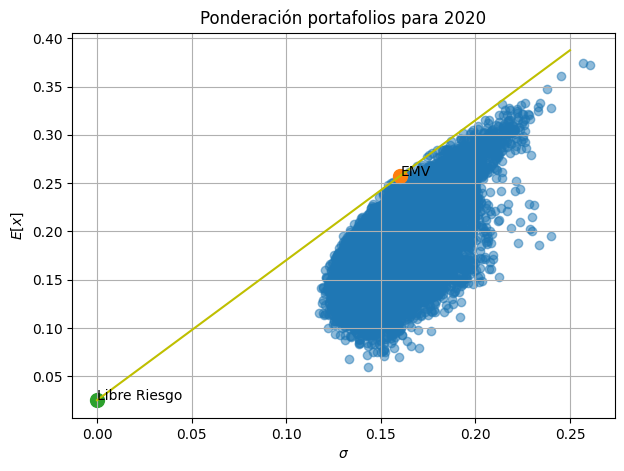

 El portafolio tiene un valor esperado del 25.7726%, con una volatilidad del 16.0386%.
 El portafolio tuvo realmente un rendimiento del 8.9333%.

2021
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un 37.5914% bonos y un 62.4086% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 29.2732%
   IBM: 0.1613%
   KO: 1.0839%
   BBY: 0.1518%
   CAT: 2.2742%
   AMZN: 2.6065%
   MGM: 2.1446%
   V: 2.4989%
   JNJ: 2.6264%
   XOM: 2.1491%
   GOOGL: 0.2153%
   CME: 1.69%
   JPM: 47.7646%
   COST: 2.4212%
   NVDA: 2.9389%


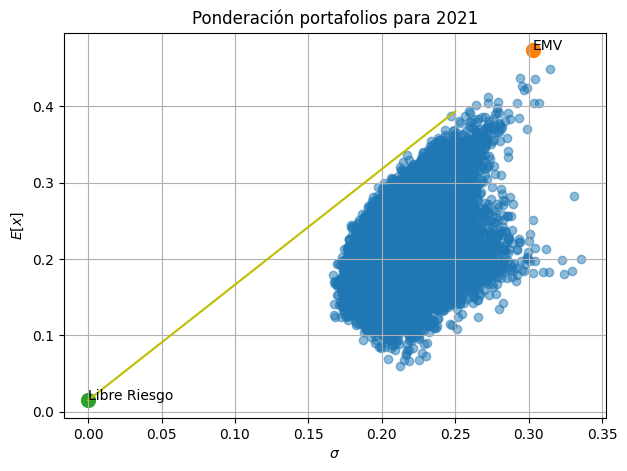

 El portafolio tiene un valor esperado del 47.3406%, con una volatilidad del 30.2945%.
 El portafolio tuvo realmente un rendimiento del 19.1203%.

2022
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un 10.515% bonos y un 89.485% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 6.8951%
   IBM: 1.7588%
   KO: 3.2039%
   BBY: 5.2168%
   CAT: 24.4453%
   AMZN: 0.0934%
   MGM: 3.0696%
   V: 0.4513%
   JNJ: 12.822%
   XOM: 0.0791%
   GOOGL: 1.9998%
   CME: 0.3713%
   JPM: 30.1318%
   COST: 8.011%
   NVDA: 1.4506%


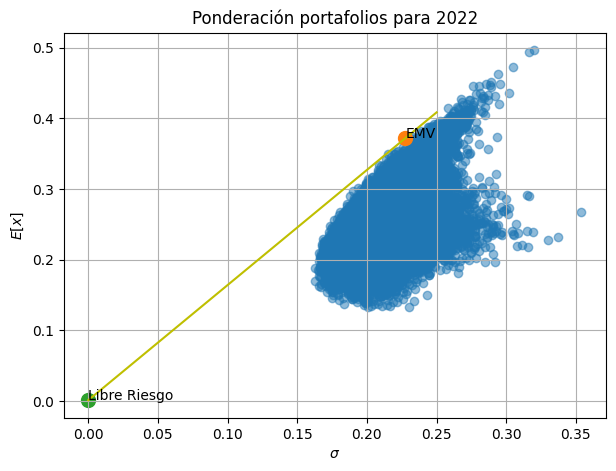

 El portafolio tiene un valor esperado del 37.1717%, con una volatilidad del 22.7563%.
 El portafolio tuvo realmente un rendimiento del -3.3%.

2023
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un 44.921% bonos y un 55.079% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 2.4851%
   IBM: 2.9485%
   KO: 16.0317%
   BBY: 1.4048%
   CAT: 29.6782%
   AMZN: 0.0084%
   MGM: 4.0599%
   V: 1.9832%
   JNJ: 4.7968%
   XOM: 1.2063%
   GOOGL: 4.2115%
   CME: 0.1818%
   JPM: 20.2038%
   COST: 3.0784%
   NVDA: 7.7216%


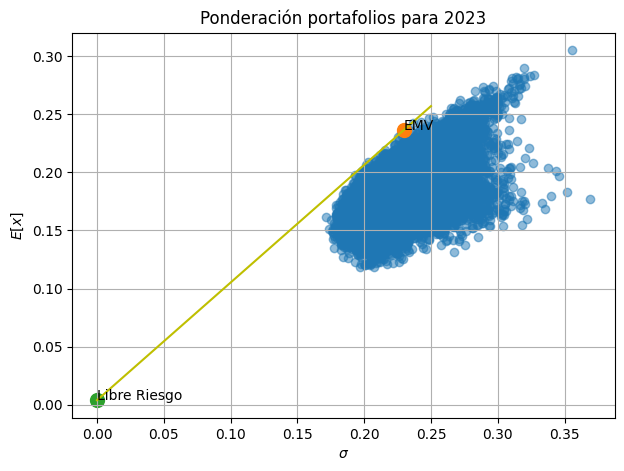

 El portafolio tiene un valor esperado del 23.6476%, con una volatilidad del 22.9744%.
 El portafolio tuvo realmente un rendimiento del 16.888%.

2024
 El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un 56.6613% bonos y un 43.3387% acciones.
 Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:
   HPQ: 14.4254%
   IBM: 4.4135%
   KO: 0.1977%
   BBY: 0.1322%
   CAT: 33.7251%
   AMZN: 0.1237%
   MGM: 2.4655%
   V: 1.9512%
   JNJ: 4.0703%
   XOM: 0.5011%
   GOOGL: 2.8624%
   CME: 2.4703%
   JPM: 28.5928%
   COST: 0.4174%
   NVDA: 3.6514%


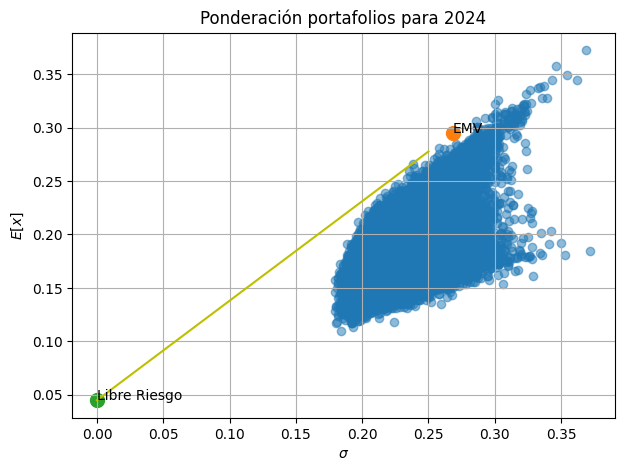

 El portafolio tiene un valor esperado del 29.4666%, con una volatilidad del 26.8347%.
 El portafolio tuvo realmente un rendimiento del 16.9928%.

El rendimiento total del portafolio durante el periodo de tenencia es del 426.9002%.
El rendimiento promedio compuesto del portafolio desde el el 2016 hasta 2024 es del 17.4996% anual.
De haber invertido $10000 USD en el 2016 y no se hubiera tocado el capital, se tendrían $42690.02 USD en 2024.


In [9]:
for i in years:
    print(i + 1)
    print(" El portafolio, con un coeficiente de aversión al riesgo de 8, está conformado por un " + str(np.round(datos[i][5] * 100, 4)) + "% bonos y un " +
          str(np.round(datos[i][6] * 100, 4)) + "% acciones.")
    print(" Dentro del porcentaje de las acciones el peso individual se distribuye de la siguiente manera:")
    for j in range(len(tickers)):
        print("   " + tickers[j] + ": " + str(np.round(datos[i][4][j] * 100, 4)) + "%")

    plt.figure(figsize=(7, 5))
    plt.scatter(datos[i][0], datos[i][1], alpha=0.5)
    plt.scatter(datos[i][2], datos[i][3], s=100)
    plt.text(datos[i][2], datos[i][3], "EMV")
    plt.plot(s, datos[i][7], c="y")
    plt.scatter(0, datos[i][8], s=100)
    plt.text(0, datos[i][8], "Libre Riesgo")
    plt.grid()
    plt.title("Ponderación portafolios para " + str(i + 1))
    plt.xlabel("$\sigma$")
    plt.ylabel("$E[x]$")
    plt.show()

    print(" El portafolio tiene un valor esperado del " + str(np.round(datos[i][3] * 100, 4)) + "%, con una volatilidad del " + str(np.round(datos[i][2] * 100, 4)) + "%.")
    print(" El portafolio tuvo realmente un rendimiento del " + str(np.round(rend_anual[i - 2015].sum() * 100, 4)) + "%.")

    print()

print("El rendimiento total del portafolio durante el periodo de tenencia es del " + str(np.round(e[-1] * 100, 4)) + "%.")
print("El rendimiento promedio compuesto del portafolio desde el el 2016 hasta 2024 es del "+ str(np.round(rend_prom * 100, 4)) + "% anual.")
print("De haber invertido $10000 USD en el 2016 y no se hubiera tocado el capital, se tendrían $" + str(np.round(monto, 2)) + " USD en 2024.")